In [1]:
import pandas as pd

# Load the events CSV (same as used before)
tariffs = pd.read_csv("../data/tariff_events_2025.csv", parse_dates=["Date"])
tariffs


,Date,Event
0,2025-02-15,Trump imposes 15% tariffs on Indian manufactur...
1,2025-03-10,India retaliates with tariffs on U.S. electron...
2,2025-04-01,Trump raises tariffs to 25% on all Indian impo...


In [2]:
event_windows = []
for _, row in tariffs.iterrows():
    event_date = row["Date"]
    window = {
        "event": row["Event"],
        "start": event_date - pd.Timedelta(days=3),
        "end": event_date + pd.Timedelta(days=3)
    }
    event_windows.append(window)

pd.DataFrame(event_windows)


,event,start,end
0,Trump imposes 15% tariffs on Indian manufactur...,2025-02-12,2025-02-18
1,India retaliates with tariffs on U.S. electron...,2025-03-07,2025-03-13
2,Trump raises tariffs to 25% on all Indian impo...,2025-03-29,2025-04-04


In [3]:
# Load manually collected headlines
headlines = pd.read_csv("../data/headlines.csv", parse_dates=["Date"])
headlines.head()


,Date,Headline
0,2025-02-13,US-India trade talks stall as tensions rise
1,2025-02-14,Trump hints at potential tariff increase on India
2,2025-02-15,Trump imposes 15% tariffs on Indian goods
3,2025-02-16,Investors react to US tariff move; markets vol...
4,2025-02-17,Experts warn of trade war escalation


In [4]:
!pip install vaderSentiment



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Compute sentiment score for each headline
headlines['Sentiment'] = headlines['Headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
headlines.head()


,Date,Headline,Sentiment
0,2025-02-13,US-India trade talks stall as tensions rise,-0.5423
1,2025-02-14,Trump hints at potential tariff increase on India,0.3182
2,2025-02-15,Trump imposes 15% tariffs on Indian goods,-0.1027
3,2025-02-16,Investors react to US tariff move; markets vol...,0.0000
4,2025-02-17,Experts warn of trade war escalation,-0.6486


In [6]:
# Tag each headline to its corresponding tariff event window
def assign_event(date):
    for window in event_windows:
        if window['start'] <= date <= window['end']:
            return window['event']
    return None

headlines['Event'] = headlines['Date'].apply(assign_event)

# Drop unrelated headlines
event_sentiment = headlines.dropna(subset=['Event'])

# Average sentiment per event
sentiment_summary = event_sentiment.groupby('Event')['Sentiment'].mean().reset_index()
sentiment_summary


,Event,Sentiment
0,India retaliates with tariffs on U.S. electron...,-0.30295
1,Trump imposes 15% tariffs on Indian manufactur...,-0.19508
2,Trump raises tariffs to 25% on all Indian impo...,0.00000


In [7]:
import pandas as pd

# Load price change data
price_change_df = pd.read_csv("../data/price_changes.csv")

# Merge sentiment with price change on the 'Event' column
final_df = pd.merge(sentiment_summary, price_change_df, on='Event')

# Show final merged result
print(final_df)


                                               Event  Sentiment        Date  \
0  India retaliates with tariffs on U.S. electron...   -0.30295  2025-03-10   
1  Trump raises tariffs to 25% on all Indian impo...    0.00000  2025-04-01   

   Pre Avg  Post Avg  % Change  
0  2354.41   2353.61     -0.03  
1  2470.12   2416.37     -2.18  


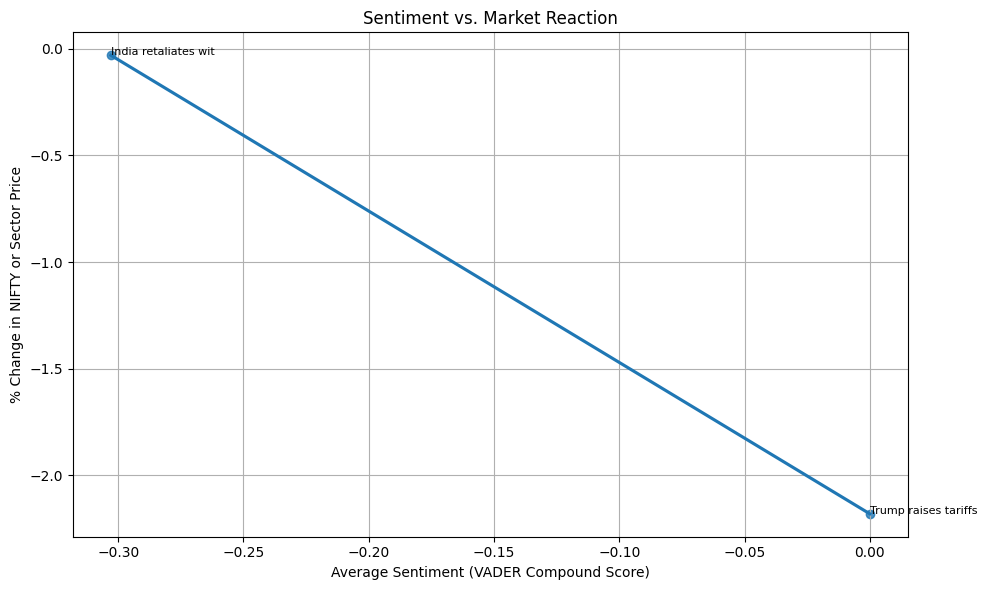

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(data=final_df, x='Sentiment', y='% Change', scatter=True, ci=None)
plt.title("Sentiment vs. Market Reaction")
plt.xlabel("Average Sentiment (VADER Compound Score)")
plt.ylabel("% Change in NIFTY or Sector Price")
plt.grid(True)

# Annotate points
for i, row in final_df.iterrows():
    plt.annotate(row['Event'][:20], (row['Sentiment'], row['% Change']), fontsize=8)

plt.tight_layout()
plt.show()
